<a href="https://colab.research.google.com/github/JackyLiu47/memeBlip/blob/main/memeBlip.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvcc --version
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install ftfy regex tqdm
!pip install yacs
!pip install torch transformers pytorch-lightning
!pip install --upgrade pytorch-lightning optuna optuna-integration

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
Looking in indexes: https://download.pytorch.org/whl/cu121


In [ ]:
# !pip install numba

# from numba import cuda
# device = cuda.get_current_device()
# device.reset()
import torch

print("CUDA Available:", torch.cuda.is_available())
print("CUDA Device Count:", torch.cuda.device_count())
print("Current Device:", torch.cuda.current_device())
print("Device Name:", torch.cuda.get_device_name(torch.cuda.current_device()))

CUDA Available: True
CUDA Device Count: 1
Current Device: 0
Device Name: NVIDIA A100-SXM4-40GB


In [ ]:
import os
from PIL import Image
import torch.nn as nn
import torchmetrics
from transformers import BlipProcessor, BlipForConditionalGeneration
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
import pandas as pd
from yacs.config import CfgNode
import numpy as np
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
if torch.cuda.is_available():
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
else:
    torch.set_default_tensor_type(torch.FloatTensor)

In [ ]:
class Custom_Dataset(Dataset):
    def __init__(self, cfg, root_folder, dataset, label, split='train', image_size=224, fast=True):
        super(Custom_Dataset, self).__init__()
        self.cfg = cfg
        self.root_folder = root_folder
        self.dataset = dataset
        self.split = split
        self.label = label

        self.image_size = image_size
        self.fast = fast

        self.info_file = cfg.info_file
        self.df = pd.read_csv(self.info_file)
        self.df = self.df[self.df['split'] == self.split].reset_index(drop=True)

        if self.label == 'target':
            self.df = self.df[self.df['hate'] == 1].reset_index(drop=True)

        float_cols = self.df.select_dtypes(float).columns
        self.df[float_cols] = self.df[float_cols].fillna(-1).astype('Int64')

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        if row['text'] == 'None':
            text = 'null'
        else:
            text = row['text']

        image_fn = row['name']
        try:
            image = Image.open(f"{self.cfg.img_folder}/{image_fn}").convert('RGB')
            image = image.resize((self.image_size, self.image_size))
        except Exception as e:
            raise ValueError(f"Error loading image {image_fn}: {e}")

        item = {
        'image': image,
        'text': text,
        'label': row[self.label],
        'idx_meme': row['name'],
        }
        return item

In [ ]:
from transformers import BlipProcessor, BlipForImageTextRetrieval, BlipConfig

class MemeBLIP_Collator:
    def __init__(self, cfg):
        self.cfg = cfg
        # Modify configuration
        blipconfig = BlipConfig.from_pretrained("Salesforce/blip-itm-large-coco")
        blipconfig.max_position_embeddings = 2048  # Extend max length if needed
        # Initialize BLIP model and processor
        self.processor = BlipProcessor.from_pretrained("Salesforce/blip-itm-large-coco")
        self.blip_model = BlipForImageTextRetrieval.from_pretrained(
            "Salesforce/blip-itm-large-coco", config=blipconfig
        ).to(self.cfg.device)
        self.blip_model.eval()

    def split_text_into_chunks(self, text, max_length):
        """
        Splits a long text into chunks of size `max_length`.
        """
        tokens = self.processor.tokenizer(
            text, return_tensors="pt", truncation=False, add_special_tokens=False
        )["input_ids"].squeeze(0).tolist()
        return [tokens[i:i + max_length] for i in range(0, len(tokens), max_length)]

    def __call__(self, batch):
        # Prepare feature lists
        image_features_list = []
        text_features_list = []

        labels = torch.LongTensor([item['label'] for item in batch]).to(self.cfg.device)
        idx_memes = [item['idx_meme'] for item in batch]

        batch_new = {
            'labels': labels,
            'idx_memes': idx_memes,
        }

        for item in batch:
            # Process image
            processed_image = self.processor(
                images=item['image'], return_tensors="pt"
            )["pixel_values"].to(self.cfg.device)

            # Process text: Split into chunks
            text_chunks = self.split_text_into_chunks(item['text'], 512)
            text_features = []

            for chunk in text_chunks:
                processed_text = {
                    "input_ids": torch.tensor([chunk]).to(self.cfg.device),
                    "attention_mask": torch.ones(len(chunk)).unsqueeze(0).to(self.cfg.device)
                }

                # Extract features for each chunk
                _, chunk_features = self.compute_features(
                    {"pixel_values": processed_image, **processed_text}
                )
                text_features.append(chunk_features)

            # Aggregate features from chunks
            text_features = torch.mean(torch.stack(text_features), dim=0)

            # Extract image features
            image_features, _ = self.compute_features(
                {"pixel_values": processed_image, **processed_text}
            )

            # Collect features
            image_features_list.append(image_features.cpu().detach())
            text_features_list.append(text_features.cpu().detach())

        # Combine features
        batch_new['image_features'] = torch.cat(image_features_list, dim=0).to(self.cfg.device)
        batch_new['text_features'] = torch.cat(text_features_list, dim=0).to(self.cfg.device)

        return batch_new

    def compute_features(self, processed):
        # Extract visual and text features from BLIP model
        vision_output = self.blip_model.vision_model(processed['pixel_values'])
        image_features = vision_output.pooler_output.to(self.cfg.device)  # Image features
        text_output = self.blip_model.text_encoder(
            input_ids=processed['input_ids'],
            attention_mask=processed['attention_mask']
        )
        text_features = text_output.last_hidden_state.mean(dim=1).to(self.cfg.device)  # Text features

        return image_features, text_features


In [ ]:
def load_dataset(cfg, split):
    dataset = Custom_Dataset(
        cfg=cfg,
        root_folder=cfg.root_dir,
        dataset=cfg.dataset_name,
        split=split,
        image_size=cfg.image_size,
        label=cfg.label,
        fast=cfg.fast_process
    )
    return dataset


In [ ]:
def create_dataloader(cfg, split="train"):
    dataset = load_dataset(cfg, split)
    subset_size = int(len(dataset) * 0.3)  # 使用 30% 的数据
    subset_indices = np.random.choice(len(dataset), subset_size, replace=False)

    # 创建子集
    subset = Subset(dataset, subset_indices)
    collator = MemeBLIP_Collator(cfg)
    generator = torch.Generator(device="cuda") if torch.cuda.is_available() else torch.Generator()
    dataloader = DataLoader(
        dataset,
        batch_size=cfg.batch_size,
        shuffle=(split == "train"),
        generator = generator,
        collate_fn=collator
    )
    return dataloader

In [ ]:
cfg = CfgNode()

# 路径设置
cfg.root_dir = './content/drive/MyDrive/Colab_Notebooks/MemeCLIP-main'
cfg.img_folder = '/content/drive/MyDrive/Colab_Notebooks/MemeCLIP-main/dataset/Images'
cfg.info_file = '/content/drive/MyDrive/Colab_Notebooks/MemeCLIP-main/dataset/PrideMM.csv'
cfg.checkpoint_path = os.path.join(cfg.root_dir, 'checkpoints')
cfg.checkpoint_file = os.path.join(cfg.checkpoint_path, 'model.ckpt')

# 模型与数据集设置
cfg.clip_variant = "ViT-L/14"
cfg.dataset_name = 'Pride'
cfg.name = 'MemeBLIP'
cfg.label = 'hate'
cfg.seed = 42
cfg.test_only = False
cfg.device = 'cuda'
cfg.gpus = [0]

# 根据任务类型动态设置类别
if cfg.label == 'hate':
    cfg.class_names = ['Benign Meme', 'Harmful Meme']
elif cfg.label == 'humour':
    cfg.class_names = ['No Humour', 'Humour']
elif cfg.label == 'target':
    cfg.class_names = ['No particular target', 'Individual', 'Community', 'Organization']
elif cfg.label == 'stance':
    cfg.class_names = ['Neutral', 'Support', 'Oppose']

# 超参数设置
cfg.batch_size = 16
cfg.image_size = 224
cfg.num_mapping_layers = 1
cfg.unmapped_dim = 768
cfg.map_dim = 1024
cfg.num_pre_output_layers = 2
cfg.drop_probs = [0.4, 0.2, 0.3]
cfg.dropout_rate = 0.5
cfg.hidden_dim = 1024
cfg.lr = 1e-4
cfg.max_epochs = 20
cfg.weight_decay = 1e-4
cfg.num_classes = len(cfg.class_names)
cfg.scale = 30
cfg.print_model = True
cfg.fast_process = True
cfg.reproduce = False
cfg.ratio = 0.7
cfg.num_layers = 3
cfg.activation = 'ReLU'
cfg.hidden_dim1 = 1024

print(cfg)


activation: ReLU
batch_size: 16
checkpoint_file: ./content/drive/MyDrive/Colab_Notebooks/MemeCLIP-main/checkpoints/model.ckpt
checkpoint_path: ./content/drive/MyDrive/Colab_Notebooks/MemeCLIP-main/checkpoints
class_names: ['Benign Meme', 'Harmful Meme']
clip_variant: ViT-L/14
dataset_name: Pride
device: cuda
drop_probs: [0.4, 0.2, 0.3]
dropout_rate: 0.5
fast_process: True
gpus: [0]
hidden_dim: 1024
hidden_dim1: 1024
image_size: 224
img_folder: /content/drive/MyDrive/Colab_Notebooks/MemeCLIP-main/dataset/Images
info_file: /content/drive/MyDrive/Colab_Notebooks/MemeCLIP-main/dataset/PrideMM.csv
label: hate
lr: 0.0001
map_dim: 1024
max_epochs: 20
name: MemeBLIP
num_classes: 2
num_layers: 3
num_mapping_layers: 1
num_pre_output_layers: 2
print_model: True
ratio: 0.7
reproduce: False
root_dir: ./content/drive/MyDrive/Colab_Notebooks/MemeCLIP-main
scale: 30
seed: 42
test_only: False
unmapped_dim: 768
weight_decay: 0.0001


In [ ]:
from torch.utils.data import Subset

data_file = "/content/drive/MyDrive/Colab_Notebooks/MemeCLIP-main/dataset/PrideMM.csv"
df = pd.read_csv(data_file)
print(df.columns)

# 加载训练和验证数据
train_loader = create_dataloader(cfg, split="train")
val_loader = create_dataloader(cfg, split="val")

Index(['name', 'hate', 'target', 'stance', 'humour', 'split', 'text'], dtype='object')


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.59k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/445 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/456 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.78G [00:00<?, ?B/s]

In [ ]:
class LinearProjection(nn.Module):
    def __init__(self, input_dim, output_dim, num_layers, drop_probs):
        super(LinearProjection, self).__init__()

        # 如果 drop_probs 是列表，取第一个值；如果是标量，直接使用
        if isinstance(drop_probs, list):
            dropout_prob = drop_probs[0]
        else:
            dropout_prob = drop_probs

        map_layers = [nn.Linear(input_dim, output_dim),
                      nn.Dropout(p=dropout_prob)]

        for _ in range(1, num_layers):
            map_layers.extend([
                nn.ReLU(),
                nn.Linear(output_dim, output_dim),
                nn.ReLU(),
                nn.Dropout(p=dropout_prob)
            ])

        self.proj = nn.Sequential(*map_layers)

    def forward(self, x):
        return self.proj(x)

class Adapter(nn.Module):
    def __init__(self, c_in, reduction=4, dropout_rate=0.1):
        super(Adapter, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(c_in, c_in // reduction, bias=False),
            nn.BatchNorm1d(c_in // reduction),
            nn.GELU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(c_in // reduction, c_in, bias=False),
            nn.BatchNorm1d(c_in),
            nn.GELU(),
            nn.Dropout(p=dropout_rate)
        )
        # Initialize weights
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            # Use Xavier initialization for GELU
            nn.init.xavier_uniform_(module.weight)
        elif isinstance(module, nn.LayerNorm):
            nn.init.ones_(module.weight)
            nn.init.zeros_(module.bias)

    def forward(self, x):
        return self.fc(x)

In [ ]:
from pytorch_lightning.callbacks import Callback

class MyCustomCallback(Callback):
    def on_train_epoch_end(self, trainer, pl_module):
        print("Epoch ended!")

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CosineClassifier(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(output_dim, input_dim))  # 可学习的权重

    def forward(self, x):
        # 计算 Cosine Similarity
        x_norm = F.normalize(x, dim=1)  # 对输入进行 L2 归一化
        w_norm = F.normalize(self.weight, dim=1)  # 对权重进行 L2 归一化
        cosine_sim = torch.matmul(x_norm, w_norm.T)  # [batch_size, output_dim]
        return cosine_sim

In [ ]:
# 偏置cosine sim
class CosineClassifierWithBias(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(output_dim, input_dim))
        self.bias = nn.Parameter(torch.zeros(output_dim))  # 偏置

    def forward(self, x):
        x_norm = F.normalize(x, dim=1)
        w_norm = F.normalize(self.weight, dim=1)
        cosine_sim = torch.matmul(x_norm, w_norm.T)
        return cosine_sim + self.bias
    def apply_weight(self, weight):
        with torch.no_grad():
            self.weight.copy_(weight)

In [ ]:
class MemeBLIP(pl.LightningModule):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg

        # 动态线性投影
        self.image_projection = LinearProjection(
            input_dim=1024,
            output_dim=cfg.map_dim,
            num_layers=1,
            drop_probs=cfg.drop_probs
        ).to(self.cfg.device)

        self.text_projection = LinearProjection(
            input_dim=768,
            output_dim=cfg.map_dim,
            num_layers=1,
            drop_probs=cfg.drop_probs
        ).to(self.cfg.device)

        # Adapter
        self.image_adapter = Adapter(cfg.map_dim, reduction=4).to(self.cfg.device)
        self.text_adapter = Adapter(cfg.map_dim, reduction=4).to(self.cfg.device)
        self.pre_output_layer = nn.Sequential(
            nn.Linear(cfg.map_dim, 512),  # 第一层：压缩特征维度
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(512, cfg.hidden_dim),  # 第二层：映射到分类器输入维度
            nn.ReLU(),
            nn.Dropout(p=0.5)
        )
        # 加载 BLIP 模型和处理器
        self.processor = BlipProcessor.from_pretrained("Salesforce/blip-itm-large-coco")
        self.model = BlipForImageTextRetrieval.from_pretrained("Salesforce/blip-itm-large-coco").to(cfg.device)

        self.map_dim = cfg.map_dim  # BLIP 模型的隐藏层大小

        # 分类器
        # 定义非线性分类头
        self.classifier = nn.Sequential(
            nn.Linear(cfg.hidden_dim, 512),  # classifier_0
            nn.GELU(),
            nn.Dropout(p=0.5),  # 增加 Dropout
            CosineClassifierWithBias(512, 256),             # classifier_2
            nn.GELU(),
            nn.Dropout(p=0.5),  # 增加 Dropout
            CosineClassifierWithBias(256, cfg.num_classes)  # classifier_4
        )
        # 初始化分类器权重
        self.init_head_text_feat()

        # 损失函数
        self.cross_entropy_loss = nn.CrossEntropyLoss()

        # 评估指标
        self.acc = torchmetrics.Accuracy(task="multiclass", num_classes=cfg.num_classes)
        self.auroc = torchmetrics.AUROC(task="multiclass", num_classes=cfg.num_classes)
        self.f1 = torchmetrics.F1Score(task="multiclass", num_classes=cfg.num_classes)
        self.model = self.model.to(cfg.device)
        self.classifier = self.classifier.to(cfg.device)
        # 存储梯度
        self.gradients = {}

    def save_gradient(self, name):
        # 定义保存梯度的钩子
        def hook(module, grad_input, grad_output):
            self.gradients[name] = grad_output[0].detach()
        return hook

    def register_hooks(self):
        # 为关键层注册钩子
        self.image_projection.proj.register_backward_hook(self.save_gradient("image_projection"))
        self.text_projection.proj.register_backward_hook(self.save_gradient("text_projection"))
        self.image_adapter.fc.register_backward_hook(self.save_gradient("image_adapter"))
        self.text_adapter.fc.register_backward_hook(self.save_gradient("text_adapter"))
        self.pre_output_layer.register_backward_hook(self.save_gradient("pre_output_layer"))

        for i, layer in enumerate(self.classifier):
            if isinstance(layer, nn.Linear):
                layer.register_backward_hook(self.save_gradient(f"classifier_{i}"))

    def init_head_text_feat(self):
        print("Initialize head with text features")

        template = "a photo of a {}."
        prompts = [template.format(c.replace("_", " ")) for c in self.cfg.class_names]

        prompts = self.processor.tokenizer(
            prompts, return_tensors="pt", padding=True, truncation=True
        ).to(self.cfg.device)

        prompts = {k: v for k, v in prompts.items() if k in ["input_ids", "attention_mask"]}

        text_features = self.model.text_encoder(**prompts).last_hidden_state.mean(dim=1)

        text_features = F.normalize(text_features, dim=-1)


        if hasattr(self.classifier[-1], 'apply_weight'):
            if text_features.size(1) != 256:
              projection = nn.Linear(text_features.size(1), 256).to(self.cfg.device)
              text_features1 = projection(text_features)
              self.classifier[-1].apply_weight(text_features1)
        else:
            print("Warning: Classifier -1 does not have 'apply_weight' method. Skipping initialization.")

    def forward(self, batch):
        # 提取特征
        image_features = batch['image_features']
        text_features = batch['text_features']

        if isinstance(image_features, tuple):
          image_features = image_features[0].to(self.cfg.device)
        if isinstance(text_features, tuple):
          text_features = text_features[0].to(self.cfg.device)

        # Linear Projection
        image_proj = self.image_projection(image_features).to(self.cfg.device)
        text_proj = self.text_projection(text_features).to(self.cfg.device)

        # Adapter
        adapted_image = self.image_adapter(image_proj).to(self.cfg.device)
        adapted_text = self.text_adapter(text_proj).to(self.cfg.device)

        text_adapted_features = self.cfg.ratio  * adapted_text + (1 - self.cfg.ratio ) * text_proj
        image_adapted_features = self.cfg.ratio  * adapted_image + (1 - self.cfg.ratio ) * image_proj

        image_adapted_features = image_adapted_features / image_adapted_features.norm(dim=-1, keepdim=True)
        text_adapted_features = text_adapted_features / text_adapted_features.norm(dim=-1, keepdim=True)

        # 特征融合
        combined_features = torch.mul(image_adapted_features, text_adapted_features).to(self.cfg.device)

        # Pre-Output Transformation
        pre_output_features = self.pre_output_layer(combined_features).to(self.cfg.device)

        logits = self.classifier(pre_output_features).squeeze(dim=1).to(self.cfg.device)
        return logits

    def common_step(self, batch):
        logits = self.forward(batch)  # 使用分类器的输出
        preds_proxy = torch.sigmoid(logits)
        _ , preds = logits.data.max(1)
        loss = self.cross_entropy_loss(logits, batch["labels"])  # 标签大小为 [batch_size]
        # preds = torch.argmax(logits, dim=-1)
        acc = self.acc(preds, batch["labels"])
        auroc = self.auroc(preds_proxy, batch['labels'])
        f1 = self.f1(preds, batch["labels"])
        return {"loss": loss, "acc": acc, "auroc": auroc, "f1": f1}

    def training_step(self, batch, batch_idx):
        logits = self.forward(batch)
        loss = self.cross_entropy_loss(logits, batch["labels"])
        preds_proxy = torch.sigmoid(logits)
        _ , preds = logits.data.max(1)
        # preds = torch.argmax(logits, dim=-1)
        acc = self.acc(preds, batch["labels"])
        auroc = self.auroc(preds_proxy, batch['labels'])
        f1 = self.f1(preds, batch["labels"])


        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log("train_acc", acc, on_step=True, on_epoch=True, prog_bar=True)
        self.log("train_auroc", auroc, on_step=True, on_epoch=True, prog_bar=True)
        self.log("train_f1", f1, on_step=True, on_epoch=True, prog_bar=True)

        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.cfg.lr, weight_decay=self.cfg.weight_decay)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
        return [optimizer], [scheduler]

    def validation_step(self, batch, batch_idx):
        # 前向传播
        logits = self.forward(batch)
        loss = self.cross_entropy_loss(logits, batch["labels"])

        preds_proxy = torch.sigmoid(logits)
        _ , preds = logits.data.max(1)
        # 预测和计算指标
        # preds = torch.argmax(logits, dim=-1)
        acc = self.acc(preds, batch["labels"])
        auroc = self.auroc(torch.softmax(logits, dim=-1), batch["labels"])
        f1 = self.f1(preds, batch["labels"])

        # 日志记录
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)
        self.log("val_auroc", auroc, prog_bar=True)
        self.log("val_f1", f1, prog_bar=True)

        return {"loss": loss, "acc": acc, "auroc": auroc, "f1": f1}

In [ ]:
import pytorch_lightning as pl
import optuna

def objective(trial):
    # # 建议的超参数
    # cfg.lr = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
    # cfg.batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    # cfg.num_pre_output_layers = trial.suggest_int("num_pre_output_layers", 1, 3)
    # cfg.hidden_dim = trial.suggest_int("hidden_dim", 128, 1024, step=128)
    # cfg.drop_probs = [trial.suggest_uniform(f"drop_prob_{i}", 0.1, 0.5) for i in range(3)]
    # cfg.num_layers = trial.suggest_int("num_layers", 1, 3)
    # cfg.activation = trial.suggest_categorical("activation", ["ReLU", "LeakyReLU", "GELU"])
    # cfg.hidden_dim1 = trial.suggest_categorical("hidden_dim1", [256, 512, 1024])


    # 创建模型
    model = MemeBLIP(cfg)

    # Trainer 配置
    trainer = pl.Trainer(
        max_epochs=cfg.max_epochs,
        accelerator="gpu",
        devices=len(cfg.gpus),
        logger=pl.loggers.TensorBoardLogger("logs/"),
        callbacks=[pl.callbacks.ModelCheckpoint(dirpath="checkpoints/")]
    )

    try:
        trainer.fit(model, train_loader, val_loader)
        validation_metrics = trainer.callback_metrics
        return validation_metrics["val_loss"].item()  # 优化目标
    except Exception as e:
        print(f"Trial failed: {e}")
        raise optuna.exceptions.TrialPruned()

# 创建 Optuna study 并运行优化
# study = optuna.create_study(direction="minimize")
# study.optimize(objective, n_trials=20)

# print("Best hyperparameters:", study.best_params)


In [ ]:
def initialize_weights(module):
    if isinstance(module, nn.Linear):
        nn.init.xavier_uniform_(module.weight)  # Xavier 初始化
        if module.bias is not None:
            nn.init.zeros_(module.bias)

In [ ]:
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint

checkpoint_callback = ModelCheckpoint(
    dirpath = cfg.checkpoint_path,  # 检查点保存路径
    filename="memeBLIP-{epoch:02d}-{val_loss:.2f}",  # 检查点文件命名
    save_top_k=1,  # 保存验证集损失最低的 1 个模型
    monitor="val_loss",  # 监控的指标
    mode="min"  # 验证集损失越低越好
)

# early_stop_callback = EarlyStopping(
#     monitor="val_loss",
#     patience=3,  # 如果验证集损失在 3 个 epoch 内没有改善，则停止训练
#     verbose=True,
#     mode="min"
# )

model = MemeBLIP(cfg)
model.register_hooks()
model.apply(initialize_weights)
model.to(cfg.device)
for name, param in model.classifier.named_parameters():
    print(f"{name}: {param.data}")

for batch in train_loader:
    model.forward(batch)  # 输出隐藏状态形状
    break
trainer = pl.Trainer(
    max_epochs=cfg.max_epochs,
    accelerator="gpu",
    devices=len(cfg.gpus),
    logger=pl.loggers.TensorBoardLogger("logs/"),
    callbacks=[checkpoint_callback]
)

from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter(log_dir='logs/gradient_logs')

for name, grad in model.gradients.items():
    writer.add_histogram(f"Gradients/{name}", grad, global_step=self.current_epoch)


# 检查模型输出
logits = model.forward(batch)
print(f"logits shape: {logits.shape}")
trainer.fit(model, train_loader, val_loader)
validation_metrics = trainer.validate(model, val_loader, verbose=True)
print("Validation Metrics:", validation_metrics)
print("Validation Accuracy:", trainer.callback_metrics["val_acc"])
print("Validation AUROC:", trainer.callback_metrics["val_auroc"])
print("Validation F1 Score:", trainer.callback_metrics["val_f1"])

Initialize head with text features
0.weight: tensor([[-0.0062, -0.0158,  0.0032,  ...,  0.0033,  0.0041,  0.0178],
        [ 0.0542,  0.0594,  0.0446,  ...,  0.0303,  0.0392,  0.0068],
        [ 0.0028, -0.0337, -0.0190,  ..., -0.0520,  0.0348, -0.0170],
        ...,
        [-0.0242,  0.0076,  0.0098,  ...,  0.0244,  0.0511, -0.0393],
        [ 0.0306,  0.0502,  0.0102,  ...,  0.0415, -0.0355, -0.0130],
        [ 0.0321, -0.0010,  0.0098,  ..., -0.0048,  0.0341,  0.0296]])
0.bias: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmu

logits shape: torch.Size([16, 2])


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name               | Type                      | Params | Mode 
--------------------------------------------------------------------------
0  | image_projection   | LinearProjection          | 1.0 M  | train
1  | text_projection    | LinearProjection          | 787 K  | train
2  | image_adapter      | Adapter                   | 526 K  | train
3  | text_adapter       | Adapter                   | 526 K  | train
4  | pre_output_layer   | Sequential                | 1.1 M  | train
5  | model              | BlipForImageTextRetrieval | 446 M  | eval 
6  | classifier         | Sequential                | 656 K  | train
7  | cross_entropy_loss | CrossEntropyLoss          | 0      | train
8  | acc                | MulticlassAccuracy        | 0      | train
9  | auroc              | MulticlassAUROC           | 0      | train
10 | f1                 | Multiclas

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 16. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (776 > 512). Running this sequence through the model will result in indexing errors
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 8. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 4. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.6666666865348816     │
│         val_auroc         │    0.6977588534355164     │
│          val_f1           │    0.6666666865348816     │
│         val_loss          │    0.6921248435974121     │
└───────────────────────────┴───────────────────────────┘

Validation Metrics: [{'val_loss': 0.6921248435974121, 'val_acc': 0.6666666865348816, 'val_auroc': 0.6977588534355164, 'val_f1': 0.6666666865348816}]
Validation Accuracy: tensor(0.6667, device='cpu')
Validation AUROC: tensor(0.6978, device='cpu')
Validation F1 Score: tensor(0.6667, device='cpu')


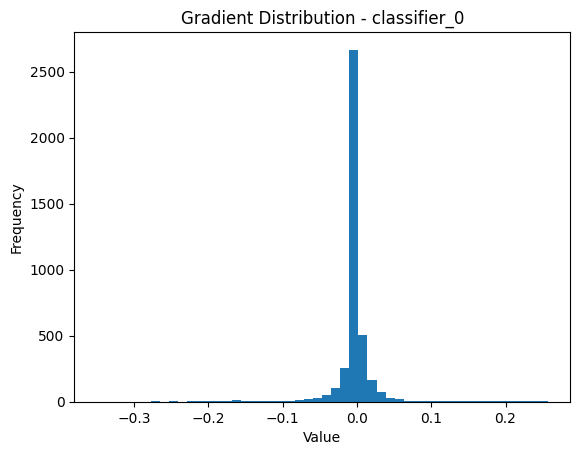

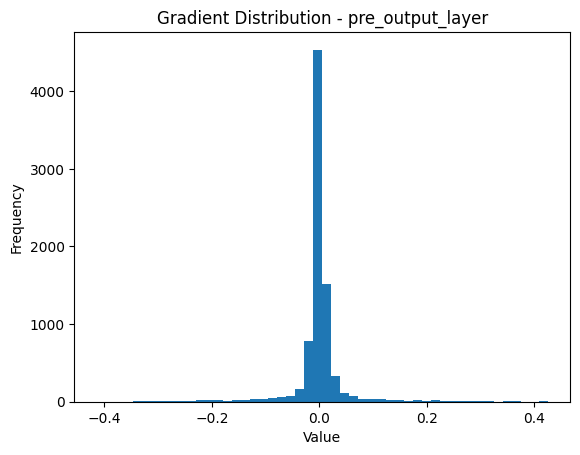

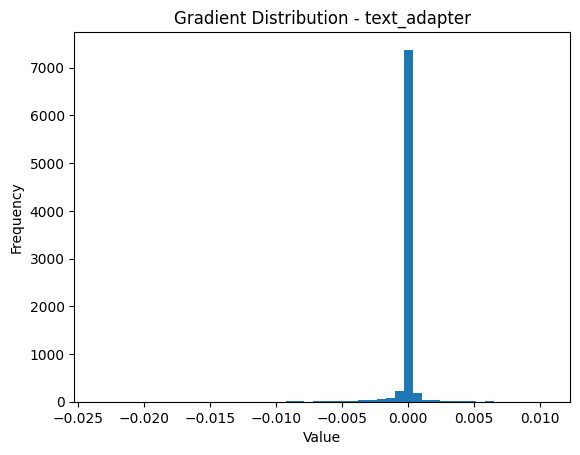

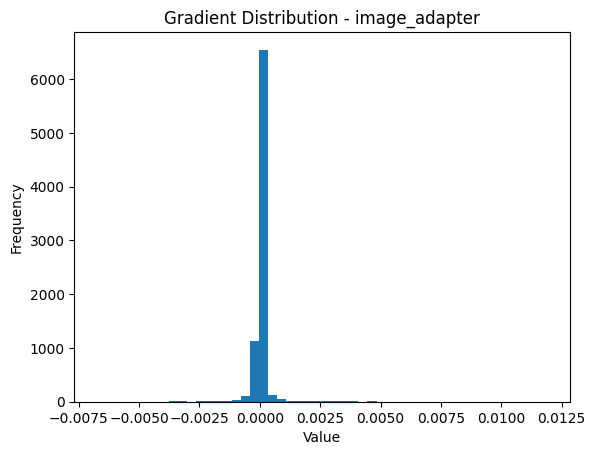

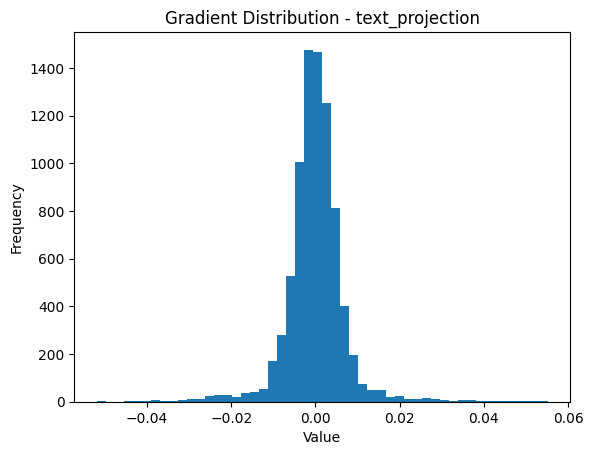

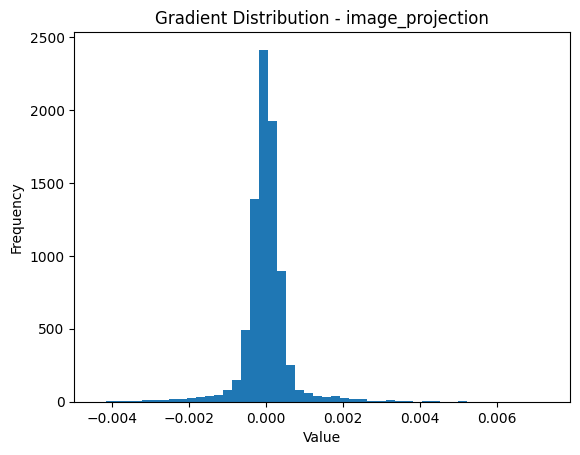

In [ ]:
import matplotlib.pyplot as plt

def plot_gradient_distribution(grad, layer_name):
    plt.hist(grad.cpu().numpy().flatten(), bins=50)
    plt.title(f"Gradient Distribution - {layer_name}")
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.show()

for name, grad in model.gradients.items():
    plot_gradient_distribution(grad, name)